In [1]:
import cv2
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

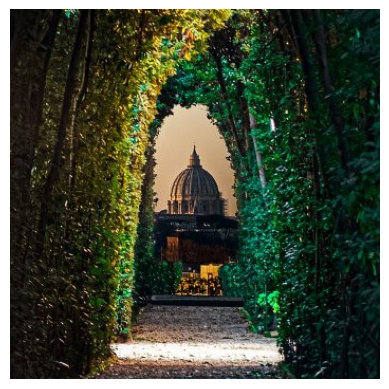

In [2]:
img = cv2.imread('roma.jpg')
my_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(my_img, cmap="gray")
plt.axis('off') 
plt.show()

In [3]:
# STEP 1: Generate Two Large Prime Numbers (p,q) randomly
# from random import randrange, getrandbits
def power(a,d,n):
  ans=1;
  while d!=0:
    if d%2==1:
      ans=((ans%n)*(a%n))%n
    a=((a%n)*(a%n))%n
    d>>=1
  return ans;

def is_probable_prime(n, k=40):
    """
    Miller-Rabin Primality Test.

    :param n: The integer to be tested.
    :param k: The number of testing rounds; more rounds lower the error probability (default is 40 rounds).
    :return: True if n is likely a prime, otherwise False.
    """
    if n < 2:
        return False
    # Check small primes. If n is divisible by one of them, then n is prime if and only if n is that prime.
    for prime in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]:
        if n % prime == 0:
            return n == prime

    # Express n - 1 as 2^r * d, where d is odd.
    r, d = 0, n - 1 #r=0, d=n-1
    while d % 2 == 0: #if d%2=0
        r += 1 #r=r+1
        d //= 2 #d=d/2

    # Perform k rounds of testing.
    for _ in range(k):
        a = random.randrange(2, n - 1) #select base a from number between 2 and n-1
        x = pow(a, d, n) #calculate a^d mod n
        if x == 1 or x == n - 1: #if x=1 or x=n-1
            continue # n passes this round
        for _ in range(r - 1): 
            x = pow(x, 2, n) #otherwise repeat x=x^2 mod n up to r−1 times.
            if x == n - 1:
                break
        else:
            return False
    return True

def generatePrimeNumber(bits):
    """
    Generate a prime number with the specified number of bits.
    
    :param bits: The number of bits for the prime (for example, 2048).
    :return: The generated prime number.
    """
    while True:
        # Randomly generate an integer with the specified number of bits.
        candidate = random.getrandbits(bits)
        # Set the highest and lowest bits to 1 to ensure that the candidate is a bits-bit odd number.
        candidate |= (1 << (bits - 1)) | 1
        if is_probable_prime(candidate):
            return candidate

if __name__ == '__main__':
    bits = 4  # Choose how many bits the prime number is.
    
    print("Generating the first prime number P, please wait...")
    P = generatePrimeNumber(bits)
    print("Generated prime P:")
    print(P)
    
    print("\nGenerating the second prime number Q, please wait...")
    Q = generatePrimeNumber(bits)
    while P == Q: #New avoid P=Q
     Q = generatePrimeNumber(bits)
    print("Generated prime Q:")
    print(Q)


Generating the first prime number P, please wait...
Generated prime P:
13

Generating the second prime number Q, please wait...
Generated prime Q:
11


In [4]:
#Step 2: Calculate N=P*Q and Euler Totient Function = (P-1)*(Q-1)
N=P*Q
eulerTotient=(P-1)*(Q-1)
print(N)
print(eulerTotient)

143
120


In [5]:
#Step 3: Find E such that GCD(E,eulerTotient)=1(i.e., e should be co-prime) such that it satisfies this condition:-  1<E<eulerTotient

def GCD(a, b): 
  if a == 0:
    return b
  return GCD(b % a, a)  # Recursive Algorithm

def choose_e(phi):
    """ Choose a prime number E between 2 and phi-1 such that GCD(E, φ(N)) = 1 """
    while True:
        E = generatePrimeNumber(bits) 
        if 2 < E < phi and math.gcd(E, eulerTotient) == 1:
            return E  # Found a suitable E, return

E = choose_e(eulerTotient)
print(E)

11


In [6]:
# Step 4: Find D. 
#For Finding D: It must satisfies this property:-  (D*E)Mod(eulerTotient)=1;
#Now we have two Choices
# 1. That we randomly choose D and check which condition is satisfying above condition.
# 2. For Finding D we can Use Extended Euclidean Algorithm: ax+by=1 i.e., eulerTotient(x)+E(y)=GCD(eulerTotient,e)
#Here, Best approach is to go for option 2.( Extended Euclidean Algorithm.)

def gcdExtended(E,eulerTotient):
  a1,a2,b1,b2,d1,d2=1,0,0,1,eulerTotient,E

  while d2!=1:

    # k
    k=(d1//d2)

    #a
    temp=a2
    a2=a1-(a2*k)
    a1=temp

    #b
    temp=b2
    b2=b1-(b2*k)
    b1=temp

    #d
    temp=d2
    d2=d1-(d2*k)
    d1=temp

    D=b2

  if D>eulerTotient:
    D=D%eulerTotient
  elif D<0:
    D=D+eulerTotient

  return D

D=gcdExtended(E,eulerTotient)
print(D)

11


In [7]:
# Get the image dimensions (number of rows and columns)
row, col = my_img.shape[0], my_img.shape[1]

# Initialize a 3000 x 3000 2D list with zeros to store the encrypted data.
# enc store the encoded image:
enc = [[0 for x in range(3000)] for y in range(3000)]

# Print the image size in the format "rows x columns"
print(f"Image size: {row}x{col}")


Image size: 350x350


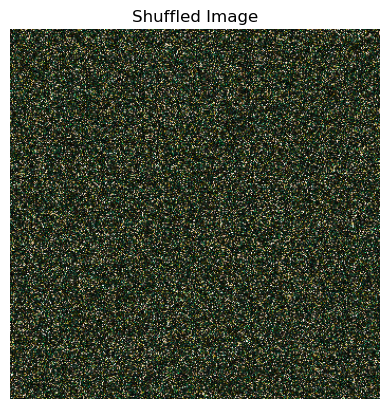

In [8]:
# Define the region to shuffle
row_start, row_end = 0, 350
col_start, col_end = 0, 350

# Extract the region and obtain its dimensions
region = my_img[row_start:row_end, col_start:col_end].copy()
region_height, region_width, channels = region.shape

# Flatten the region to a 2D array: each row is a pixel [R, G, B]
flat_region = region.reshape(-1, channels)

# Set private key D as fixed_seed for reproducible shuffling *OUR ORIGINAL IDEAR: PRIVATE KEY AS SEED
fixed_seed = D
np.random.seed(fixed_seed)

# Generate a permutation of indices for the flattened region
perm_indices = np.arange(flat_region.shape[0])
np.random.shuffle(perm_indices)

# Compute the inverse permutation for recovery  *Only knowing private key can compute inv_indices
inv_indices = np.empty_like(perm_indices)
inv_indices[perm_indices] = np.arange(flat_region.shape[0])

# Apply the permutation to shuffle the pixels
shuffled_flat = flat_region[perm_indices]
shuffled_region = shuffled_flat.reshape(region_height, region_width, channels)

# Replace the region in the original image with the shuffled region
my_img[row_start:row_end, col_start:col_end] = shuffled_region

plt.imshow(my_img)
plt.axis('off')
plt.title("Shuffled Image")
plt.show()

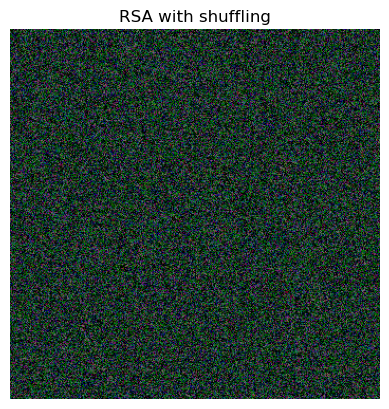

In [9]:
# Step 5: Encryption (Split encryption)
for i in range( 0, 350):
    for j in range( 0, 350):
        r, g, b = my_img[i, j]  # Get RGB color channels
        
        # Split into high 4 bits and low 4 bits
        r1, r2 = r // 16, r % 16
        g1, g2 = g // 16, g % 16
        b1, b2 = b // 16, b % 16
        
        # Encrypt
        C_r1 = power(r1, E, N)
        C_r2 = power(r2, E, N)
        C_g1 = power(g1, E, N)
        C_g2 = power(g2, E, N)
        C_b1 = power(b1, E, N)
        C_b2 = power(b2, E, N)
        
        # Store the complete encrypted values (for easier decryption)
        enc[i][j] = [C_r1, C_r2, C_g1, C_g2, C_b1, C_b2]
        
        # For display, scale encrypted values to the range 0-255
        my_img[i, j] = [(C_r1 % 256), (C_r2 % 256), (C_g1 % 256)]

plt.imshow(my_img)
plt.title("RSA with shuffling")
plt.axis('off')
plt.show()


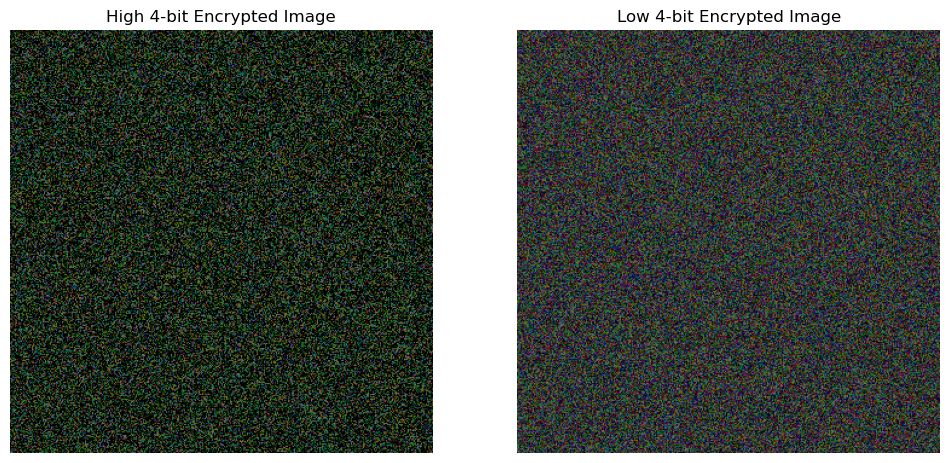

In [142]:
# After your Step 5 encryption loop, assuming "enc" is populated:

# Create copies of the original image (or new arrays) for displaying the high and low images.
# We'll initialize them with zeros having the same shape as my_img.
high_image = np.copy(my_img)  
low_image  = np.copy(my_img)

# Process only the defined region.
for i in range(0, 350):
    for j in range(0, 350):
        # Retrieve the six encrypted values for the pixel at (i, j)
        C_r1, C_r2, C_g1, C_g2, C_b1, C_b2 = enc[i][j]
        
        # For high 4-bit image, we display the high part of each channel.
        # We take the result mod 256 to bring it to the 8-bit display range.
        high_image[i, j] = [C_r1 % 256, C_g1 % 256, C_b1 % 256]
        
        # For low 4-bit image, we display the low part of each channel.
        low_image[i, j]  = [C_r2 % 256, C_g2 % 256, C_b2 % 256]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(high_image)
plt.axis('off')
plt.title("High 4-bit Encrypted Image")

plt.subplot(1, 2, 2)
plt.imshow(low_image)
plt.axis('off')
plt.title("Low 4-bit Encrypted Image")
plt.show()

Notice that the image above already combined with shuffling

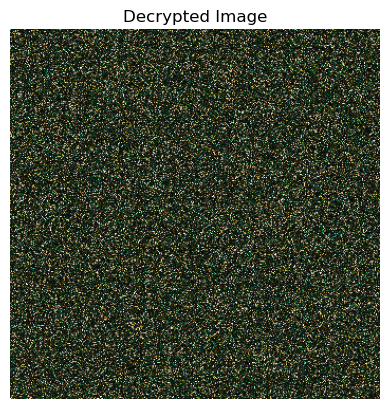

In [131]:
# Step 6: Decryption (Merge decryption)
for i in range( 0, 350):
    for j in range( 0, 350):
        C_r1, C_r2, C_g1, C_g2, C_b1, C_b2 = enc[i][j]
        
        # Decrypt
        M_r1 = power(C_r1, D, N)
        M_r2 = power(C_r2, D, N)
        M_g1 = power(C_g1, D, N)
        M_g2 = power(C_g2, D, N)
        M_b1 = power(C_b1, D, N)
        M_b2 = power(C_b2, D, N)

        # Combine back into 8-bit color
        r = (M_r1 * 16) + M_r2
        g = (M_g1 * 16) + M_g2
        b = (M_b1 * 16) + M_b2

        # Assign back to the image
        my_img[i, j] = [r, g, b]

plt.imshow(my_img)
plt.axis('off')
plt.title("Decrypted Image")
plt.show()


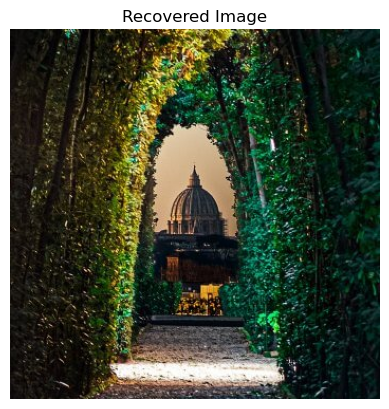

True

In [132]:

# ----- Recovery-----
# Apply the inverse permutation
# inv_indices is generated by Private key, ensure the security

# Extract the (currently shuffled) region
shuffled_region_recovered = my_img[row_start:row_end, col_start:col_end]
flat_shuffled = shuffled_region_recovered.reshape(-1, channels)

# Use the stored inverse permutation to recover original ordering
recovered_flat = flat_shuffled[inv_indices]
recovered_region = recovered_flat.reshape(region_height, region_width, channels)

# Replace the region in the image with the recovered region
my_img[row_start:row_end, col_start:col_end] = recovered_region

plt.imshow(my_img)
plt.axis('off')
plt.title("Recovered Image")
plt.show()
cv2.imwrite("C:/Users/Clay/Desktop/RSA/RSA-master/Python/recovered.jpg", cv2.cvtColor(my_img, cv2.COLOR_RGB2BGR))